# Sentiment Analysis from Tweets (after preprocessing)

In [1]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np

import re
import nltk
from nltk.stem import WordNetLemmatizer
from string import punctuation
from nltk import ngrams
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.model_selection import train_test_split
#from nltk.corpus import stopwords


In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

In [2]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""

    #added encoding
    with open(path, encoding="utf8") as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))
        #return raw_data


def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

# Input and Basic preprocessing

In [3]:
def parse_data_line(data_line):
    #Will return a tuple of the label i.e. positive or negative and text
    label = data_line[1]
    text = data_line[2]

    return (label, text)

In [4]:
def extract_ngrams(tokens):
    return [' '.join(ngram) for ngram in ngrams(tokens, 2)]

def pre_process(text):

    # Seperate the puncuation from the beginning and end of the sentence, and split the words along the whitespaces
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)
    tokens = re.split(r"\s+",text)

    lemmatizer = WordNetLemmatizer()
    #stemmer = PorterStemmer()
    tokens = [lemmatizer.lemmatize(t.lower()) for t in tokens if t.isalpha]
    #tokens = [stemmer.stem(t.lower()) for t in tokens if t.isalpha()]

    #Normalisation of the tokens by shifting the words to lowercase
    tokens = [t.lower() for t in tokens]

    ngrams_list = []
    for n in range(2, 4):
      ngrams_list.extend(list(ngrams(tokens, n)))

    flattened_ngrams = [' '.join(gram) for gram in ngrams_list]

    return tokens + flattened_ngrams

# Basic Feature Extraction

In [5]:
global_feature_dict = {}  # A global dictionary of features

def to_feature_vector(tokens):
    """
    Convert a list of preprocessed tokens into a binary feature vector.
    Tokens present in the text will have a value of 1 in the feature vector.
    The global feature dictionary keeps track of the count of each token.
    """
    feature_vector = {}
    
    for token in tokens:
        # Update the local feature vector with binary values
        feature_vector[token] = 1
        
        # Update the global feature dictionary with word counts
        if token in global_feature_dict:
            global_feature_dict[token] += 1
        else:
            global_feature_dict[token] = 1
            
    return feature_vector

In [6]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    # Creating a pipeline with LinearSVC
    pipeline =  Pipeline([('svc', LinearSVC(dual='auto'))]) # Explicitly set the dual parameter
    # Train the classifier using SklearnClassifier
    ClassifierRes = SklearnClassifier(pipeline).train(data)

    return ClassifierRes

# Cross-validation

In [7]:
#solution
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import pandas as pd


def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset)/folds) + 1
    
    for i in range(0,len(dataset),int(fold_size)):
        # insert code here that trains and tests on the 10 folds of data in the dataset
        # Define the training and testing sets for this fold
        train_data = dataset[:i] + dataset[i + fold_size:]
        test_data = dataset[i:i + fold_size]

        # Print the range of indices for the current fold
        print("Fold start on items %d - %d" % (i, i+fold_size))
        # FILL IN THE METHOD HERE
            
        # Train the classifier on the training data
        classifier = train_classifier(train_data)

        # Extract the texts and true labels from the test data
        test_texts = [text for (text, label) in test_data]
        test_labels = [label for (text, label) in test_data]

        # Predict labels on the test data
        predictions = predict_labels(test_texts, classifier)

        # Calculate precision, recall, f1-score, and accuracy
        precision, recall, f1_score, trashVar = precision_recall_fscore_support(test_labels, predictions, average='weighted')
        accuracy = accuracy_score(test_labels, predictions)

        # Store the results
        results.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        })

    # Convert the results to a DataFrame for easy viewing and analysis
    cv_results = pd.DataFrame(results)

    # Return the average metrics across all folds
    return cv_results.mean()

In [8]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    return classifier.classify(to_feature_vector(preProcess(sample)))

In [9]:
# MAIN

# loading reviews
# initialize global lists that will be appended to by the methods below
raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

split_and_preprocess_data(0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33540 rawData, 0 trainData, 0 testData
Preparing training and test data...
After split, 33540 rawData, 26832 trainData, 6708 testData
Training Samples: 
26832
Features: 
900385


In [10]:
cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

Fold start on items 0 - 2684
Training Classifier...
Fold start on items 2684 - 5368
Training Classifier...
Fold start on items 5368 - 8052
Training Classifier...
Fold start on items 8052 - 10736
Training Classifier...
Fold start on items 10736 - 13420
Training Classifier...
Fold start on items 13420 - 16104
Training Classifier...
Fold start on items 16104 - 18788
Training Classifier...
Fold start on items 18788 - 21472
Training Classifier...
Fold start on items 21472 - 24156
Training Classifier...
Fold start on items 24156 - 26840
Training Classifier...


accuracy     0.866728
precision    0.865447
recall       0.866728
f1_score     0.864824
dtype: float64

# Error Analysis

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

Training Classifier...


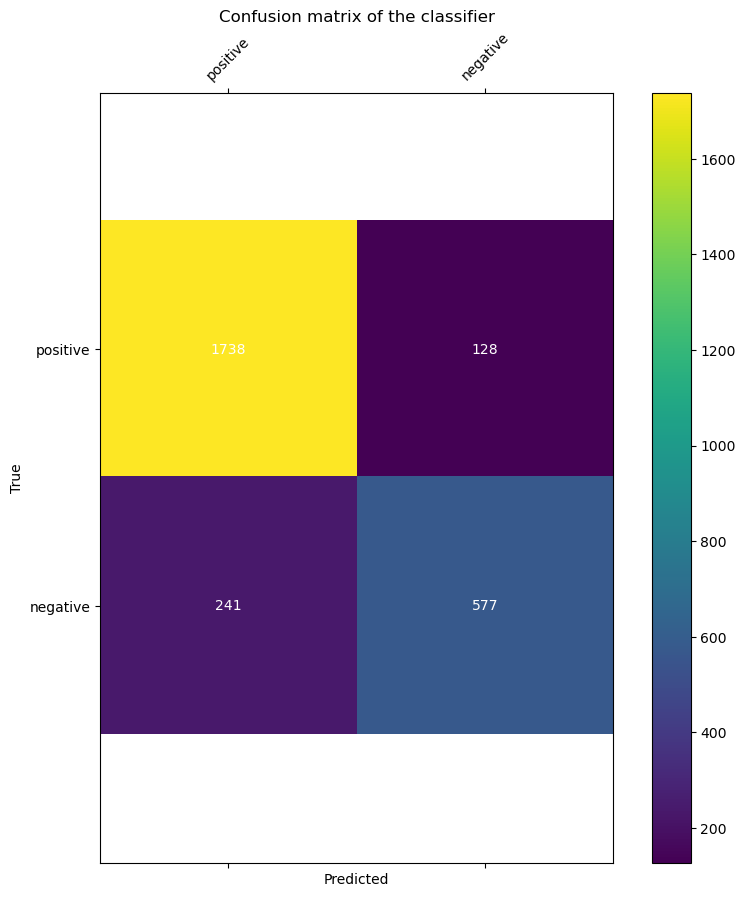

In [12]:
train_df,test_df= train_data[2684:21472], train_data[0:2684]
samples = [text for text,label in test_df]
y_test = [label for text,label in test_df]

model= train_classifier(train_df)
pred = predict_labels(samples, model)

confusion_matrix_heatmap(y_test, pred, ['positive','negative'])

# Optimising pre-processing and feature extraction

In [13]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'tomorrow': 1, 'we': 1, "'": 1, 'll': 1, 'release': 1, 'our': 1, '58th': 1, 'episode': 1, 'of': 1, '#hsonair': 1, 'profiling': 1, 'very': 1, 'own': 1, '@alissadossantos': 1, '!': 1, 'talk': 1, 'about': 1, 'storytelling': 1, 'and': 1, 'beyonce': 1, 'tomorrow we': 1, "we '": 1, "' ll": 1, 'll release': 1, 'release our': 1, 'our 58th': 1, '58th episode': 1, 'episode of': 1, 'of #hsonair': 1, '#hsonair profiling': 1, 'profiling our': 1, 'our very': 1, 'very own': 1, 'own @alissadossantos': 1, '@alissadossantos !': 1, '! we': 1, 'll talk': 1, 'talk about': 1, 'about storytelling': 1, 'storytelling and': 1, 'and beyonce': 1, 'beyonce !': 1, "tomorrow we '": 1, "we ' ll": 1, "' ll release": 1, 'll release our': 1, 'release our 58th': 1, 'our 58th episode': 1, '58th episode of': 1, 'episode of #hsonair': 1, 'of #hsonair profiling': 1, '#hsonair profiling our': 1, 'profiling our very': 1, 'our very own': 1, 'very own @alissadossantos': 1, 'own @alissadossantos !': 1, '@alissadossantos ! we': 